In [1]:
# 清空内核状态
%reset -f

In [2]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(123456)

In [3]:
#要设置的参数
Ex=0#E也要放小e6倍，这里是0就不放了
Ey=0
Ez=0#托卡马克里面没电场
B0=5#磁轴中心的磁感应强度为5T
q=2.5#安全因子，注意，不是电荷
R0=6.2#托卡马克大半径6.2m
q_over_m = 4.822452834e1  # 电荷与质量之比

#单位问题：跑太大的数，程序吃不消，得归一化。几个大数，q_over_m = 4.8e7，vx0vy0 1e6 5e6，interval 4.1473e-9，要动
#程序中，要让轨迹相对形状不变，又因为B和位置有关，所以轨迹数值也不能变
#a=q/m（E+vB），x=vt+0.5at^2
#让位移x=vt+0.5at^2不变，让interval扩大e6倍，让v缩小e6倍(让v0和x0在同一量级，这样好训练)，让q_over_m缩小e6倍，E也要放小e6倍，这样a放小e12个
def Bx(x,y,z):
    return B0/q*(-q*R0*y+z*x)/(x**2+y**2)
def By(x,y,z):
    return B0/q*(q*R0*x+z*y)/(x**2+y**2)
def Bz(x,y,z):
    return B0/q*(-1+R0/(x**2+y**2)**0.5)
    

target_x0=torch.tensor([7.2])
target_y0=torch.tensor([0.0])
target_z0=torch.tensor([0.0])
target_vx0=torch.tensor([1.0])
target_vy0=torch.tensor([5.0])#这里是通行α粒子数据
target_vz0=torch.tensor([0.0])


interval=4.147267104135095e-4#根据学长给的数据取值,e-3是小圈的1/2π,e-4就是小圈的60分之一，更精确
#总运动时间是n*interval
learning_rate=2e-3

stop_condition = 5e-4#停止训练的loss值要求


#设置初始权重
lamda1=1#lpde权重
lamda2=400#lE权重
lamda3=600#l0权重




In [47]:
n=50#训练中的t共n个时间点,注意画三维图的点不建议超过200个，容易炸内核
n_all=10000#总覆盖时间点数，绘图用
jump=0#单位是interval
n_epoch=10#每几次epoch就计数

n_test=50#在n_all范围内，等距取多少个test点
new_prefix = "8.2.changgu"  # 新的文件名前缀

In [5]:
#Neural Network
#t作为输入，x,y,z作为输出，中间三个隐藏层
#MLP是最基础的全连接神经网络

class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        self.a = nn.Parameter(torch.tensor(0.1))  # 将a设置为可学习的参数

    def forward(self, x):
        return torch.sin(self.a *10* x)

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1,128),#0层
            SinActivation(),#1层
            torch.nn.Linear(128,128),#2层
            SinActivation(),#3
            torch.nn.Linear(128,128),#4
            SinActivation(),#5
            torch.nn.Linear(128,128),#6
            SinActivation(),#7
            torch.nn.Linear(128,3),#8
        )
         # 对每个线性层进行Glorot初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    def forward(self,x):
        return self.net(x)
    
    
u = MLP()  # 网络名称



In [6]:
# import torch
# #from ceshi_Copy1 import MLP  # 导入你的模型类定义

# # 创建模型实例
# # u = MyModel()

# # 加载模型参数
# u.load_state_dict(torch.load('3.1.1保存.pth'))

# # 设置模型为评估模式（如果只是进行推理）
# # u.eval()

In [7]:


#下面是求导
def gradients(x,t,order=1):
    if order == 1:
        return torch.autograd.grad(x,t,grad_outputs=torch.ones_like(x),#用于计算某个标量相对于一组输入张量的梯度
                                  create_graph = True,
                                  only_inputs=True,)[0]#create_graph： 这是一个布尔值，如果设置为 True，则创建一个用于计算更高阶梯度的计算图。
                                                    #这对于执行高阶梯度的操作是有用的。在训练深度学习模型时，可能需要计算模型参数的二阶梯度。
    else:
        return gradients(gradients(x,t),t,order = order-1)#二阶及以上导

In [8]:


#损失函数
#LOSS
loss = torch.nn.MSELoss()
tensortarget = (target_vx0**2+target_vy0**2+target_vz0**2)**0.5*0.98
target_initial = tensortarget.repeat(n+1).view(-1, 1)#保能量项用的

def funcmiu(x,y,z,vx,vy,vz):
    miu=(vx**2+vy**2+vz**2)/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**0.5-(vx*Bx(x,y,z)+vy*By(x,y,z)+vz*Bz(x,y,z))**2/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**1.5
    return miu


def LOSS(u):
    
    samples = torch.arange(jump*interval, (n_all+1+jump)*interval, step=int(n_all/n)*interval)#+torch.rand(n+1) * interval*int(n_all/n)*1   #random jitter to samples 10%#实际上n+1个点
    t = samples.view(-1, 1).requires_grad_(True)
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

    t0=torch.tensor([0.0]).requires_grad_(True)
    l00=(u(t0)[0] - target_x0)**2
    l01=(u(t0)[1] - target_y0)**2
    l02=(u(t0)[2] - target_z0)**2
    l03=(gradients(u(t0)[0],t0,1) - target_vx0)**2
    l04=(gradients(u(t0)[1],t0,1) - target_vy0)**2
    l05=(gradients(u(t0)[2],t0,1) - target_vz0)**2
    l0=l00+l01+l02+l03+l04+l05

    return lpde,lE,l0


In [9]:
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)
def funcweight(lpde):
    lpde.backward(retain_graph=True)#初态只对第0层的weight的梯度才全是0，其他情况都有梯度
    # 获取网络的参数列表
    gradientlw0 = u.net[0].weight.grad.clone()
    gradientlb0 = u.net[0].bias.grad.clone()
    gradientlw2 = u.net[2].weight.grad.clone()
    gradientlb2 = u.net[2].bias.grad.clone()
    gradientlw4 = u.net[4].weight.grad.clone()
    gradientlb4 = u.net[4].bias.grad.clone()
    gradientlw6 = u.net[6].weight.grad.clone()
    gradientlb6 = u.net[6].bias.grad.clone()
    gradientlw8 = u.net[8].weight.grad.clone()
    gradientlb8 = u.net[8].bias.grad.clone()
    opt.zero_grad()
    tensors_l = [gradientlw0,gradientlb0,gradientlw2,gradientlb2,gradientlw4,gradientlb4,gradientlw6,gradientlb6,
                gradientlw8,gradientlb8]
    squared_sums = [torch.sum(tensor ** 2) for tensor in tensors_l]
    # 将所有平方和相加
    total_squared_sum = sum(squared_sums)
    l2_norm_gradient_l=(total_squared_sum.item())**0.5
    return l2_norm_gradient_l

In [10]:
# 加载文本文件
xdata = np.loadtxt('通行x_real.txt')
# 从第四个数据开始，每隔10个数据读取一个，共读取50个数据
xselected_data = xdata[jump::int(n_all/n_test)][:(n_test+1)]
# 将所选数据转换为PyTorch张量
x_real = torch.tensor(xselected_data, dtype=torch.float32).view(-1,1)

ydata = np.loadtxt('通行y_real.txt')
yselected_data = ydata[jump::int(n_all/n_test)][:(n_test+1)]
y_real = torch.tensor(yselected_data, dtype=torch.float32).view(-1,1)

zdata = np.loadtxt('通行z_real.txt')
zselected_data = zdata[jump::int(n_all/n_test)][:(n_test+1)]
z_real = torch.tensor(zselected_data, dtype=torch.float32).view(-1,1)



#全500点，用于后续绘图
x_plt=xdata[jump:(n_all+1+jump):1]
y_plt=ydata[jump:(n_all+1+jump):1]
z_plt=zdata[jump:(n_all+1+jump):1]
x_real_plt=torch.tensor(x_plt, dtype=torch.float32).view(-1,1)#真实值的0~500点，
y_real_plt=torch.tensor(y_plt, dtype=torch.float32).view(-1,1)
z_real_plt=torch.tensor(z_plt, dtype=torch.float32).view(-1,1)
vxdata = (np.loadtxt('通行vx_real.txt'))*1e-6
vydata = (np.loadtxt('通行vy_real.txt'))*1e-6
vzdata = (np.loadtxt('通行vz_real.txt'))*1e-6
vx_real_plt=torch.tensor(vxdata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
vy_real_plt=torch.tensor(vydata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
vz_real_plt=torch.tensor(vzdata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
xdata=[]
ydata=[]
zdata=[]
vxdata=[]
vydata=[]
vzdata=[]#清空这二百四十万个数据

#x_real：用于训练过程神经网络输出值与真实值对比，3，13,23…493共50个时刻点，对应t_test
#x_real_plt：用于绘制真实图，0~500全点


In [11]:
#训练过程中记录的量
loss_list=[]#总损失，带权重
lpde_list=[]#方程项损失
l0_list=[]#初态损失
lE_list=[]#能量项损失loss，也是与真实能量做对比diff
lamda1_list=[]#方程项权重，把保能量保磁矩也放在这一项
lamda2_list=[]#能量项权重
lamda3_list=[]#初态权重
l_withoutweight_list=[]#总损失，不带权重
time_list=[]#训练时间记录
loss_test_list=[]#部分时刻点，输出位置与真实位置误差向量的模平方，即位置与真实值的误差
lossmean_test_list=[]#部分时刻点，输出位置与真实位置误差的算术平均值，(sigma（xn+yn+zn）-sigma(xc+yc+zc))/n ,证明轨迹可以视为导心
miu_train_list=[]

In [12]:
import time
start_time = time.time()#计时
epochs = 2000  #训练次数
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)

for i in range(epochs):
    opt.zero_grad()
    
    lpde=LOSS(u)[0]
    lE=LOSS(u)[1]
    l0=LOSS(u)[2]
  
    if (i+1)%1000== 0:
        gradient_lpde=funcweight(lpde)
        gradient_lE=funcweight(lE)
        gradient_l0=funcweight(l0) 

    if (i+1)%1000== 0 and lpde>1e-5:
        lamda1=0.2*lamda1+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_lpde  )
    if (i+1)%1000== 0 and l0>1e-5:
        lamda3=0.2*lamda3+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_l0  )
    if (i+1)%1000== 0 and lE>1e-5:
        lamda2=0.2*lamda2+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_lE  )
        
    l_total=lamda1*lpde+lamda3*l0*5+lamda2*lE
    l_withoutweight=lpde+l0+lE
    l_total.backward()
    opt.step()
    
    
    if (i+1)%200 == 0:
        learnr = opt.param_groups[0]['lr']
        
        #更新学习率
        learning_rate *=0.5
        for param_group in opt.param_groups:
            param_group['lr'] = learning_rate
    
    
    

    if (i+1)%n_epoch == 0 or i==0:
        end_time = time.time()
        total_time = end_time - start_time
        learnr = opt.param_groups[0]['lr']
        time_test =torch.arange(interval*jump, interval*(n_all+1+jump), interval*int(n_all/n_test))
        t_test = time_test.view(-1, 1).requires_grad_(True)
        x_test = u(t_test)[:, 0].view(-1, 1)
        y_test = u(t_test)[:, 1].view(-1, 1)
        z_test = u(t_test)[:, 2].view(-1, 1)
        vx_test = gradients(x_test,t_test,1)
        vy_test = gradients(y_test,t_test,1)
        vz_test = gradients(z_test,t_test,1)
        loss_test = loss(x_test,x_real)+loss(y_test,y_real)+loss(z_test,z_real)
        miu_train=funcmiu(x_test,y_test,z_test,vx_test,vy_test,vz_test)
        #lcq=lE+lmiu_test#注意这里！！
        lossmean_test = torch.sum(x_test-x_real+y_test-y_real+z_test-z_real)/n
        print(f'Epoch [{i+1}/{epochs}], Loss: {l_total.item():.4g},   LOSS_function: {lpde.item():.4g},   LOSS_E:{lE.item():.4g},    LOSS_initial: {l0.item():.4g},')
        print(f'lamda1:{lamda1:.4g},    lamda2:{lamda2:.4g},    lamda3:{lamda3:.4g},      learn rate:{learnr:.4g},    time: {total_time}' )
        print(f'loss_compared with real:{loss_test:.5g},   miu_train:{miu_train.mean():.4g},    lossmean:{lossmean_test.item():.4g}') 
        loss_list.append(l_total.item())
        lpde_list.append(lpde.item())
        l0_list.append(l0.item())
        lE_list.append(lE.item())
        lamda1_list.append(lamda1)
        lamda2_list.append(lamda2)
        lamda3_list.append(lamda3)
        l_withoutweight_list.append(l_withoutweight.item())
        time_list.append(total_time)
        loss_test_list.append(loss_test.item())
        lossmean_test_list.append(lossmean_test.item())
        miu_train_list.append(miu_train.mean())
    
    if (i+1)%4000 == 0:
        for name, param in u.named_parameters():
            if 'a' in name:  # 筛选出包含'a'的参数
                print(name, param)
        
        
    if l_total <= stop_condition:#刚才写成loss_test了，感觉不妥，毕竟应该不知道真实数字是多少
        print(f'Training stopped at No.{i+1} time. Loss ({l_total}) is below the specified threshold ({stop_condition}).')
        break


Epoch [1/2000], Loss: 3.418e+05,   LOSS_function: 1.28e+05,   LOSS_E:24.34,    LOSS_initial: 68.01,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 0.1276569366455078
loss_compared with real:55.066,   miu_train:0.01189,    lossmean:-0.8319
Epoch [10/2000], Loss: 7.623e+04,   LOSS_function: 554.8,   LOSS_E:21.61,    LOSS_initial: 22.34,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 0.5615246295928955
loss_compared with real:97.738,   miu_train:0.006912,    lossmean:4.455
Epoch [20/2000], Loss: 3.331e+04,   LOSS_function: 1535,   LOSS_E:16.14,    LOSS_initial: 8.44,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 1.0597522258758545
loss_compared with real:62.337,   miu_train:0.01194,    lossmean:5.451
Epoch [30/2000], Loss: 1.009e+04,   LOSS_function: 876.2,   LOSS_E:13.11,    LOSS_initial: 1.323,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 1.5821635723114014
loss_compared with real:39.1

Epoch [320/2000], Loss: 363.9,   LOSS_function: 222.8,   LOSS_E:0.0533,    LOSS_initial: 0.03992,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.001,    time: 16.270805597305298
loss_compared with real:0.016467,   miu_train:0.003375,    lossmean:0.114
Epoch [330/2000], Loss: 895.4,   LOSS_function: 654.5,   LOSS_E:0.04794,    LOSS_initial: 0.07391,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.001,    time: 16.764028787612915
loss_compared with real:0.017456,   miu_train:0.003166,    lossmean:0.08732
Epoch [340/2000], Loss: 625,   LOSS_function: 343.1,   LOSS_E:0.04025,    LOSS_initial: 0.08858,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.001,    time: 17.263574600219727
loss_compared with real:0.042632,   miu_train:0.002386,    lossmean:0.2379
Epoch [350/2000], Loss: 344.1,   LOSS_function: 198.1,   LOSS_E:0.0425,    LOSS_initial: 0.04301,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.001,    time: 17.764771938323975
loss_compared with 

Epoch [630/2000], Loss: 225.3,   LOSS_function: 121.2,   LOSS_E:0.01225,    LOSS_initial: 0.03304,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.00025,    time: 31.32324743270874
loss_compared with real:0.014139,   miu_train:0.00358,    lossmean:-0.05893
Epoch [640/2000], Loss: 216.4,   LOSS_function: 187.9,   LOSS_E:0.01126,    LOSS_initial: 0.007985,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.00025,    time: 31.802823305130005
loss_compared with real:0.012284,   miu_train:0.004671,    lossmean:-0.0502
Epoch [650/2000], Loss: 207.4,   LOSS_function: 136.9,   LOSS_E:0.01118,    LOSS_initial: 0.02201,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.00025,    time: 32.306734800338745
loss_compared with real:0.017453,   miu_train:0.003881,    lossmean:-0.06044
Epoch [660/2000], Loss: 402.6,   LOSS_function: 304.1,   LOSS_E:0.009826,    LOSS_initial: 0.03149,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.00025,    time: 32.834009885787964
lo

Epoch [940/2000], Loss: 145.6,   LOSS_function: 97.37,   LOSS_E:0.006403,    LOSS_initial: 0.01522,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.000125,    time: 47.521612882614136
loss_compared with real:0.0223,   miu_train:0.004788,    lossmean:-0.1004
Epoch [950/2000], Loss: 451.5,   LOSS_function: 361,   LOSS_E:0.006652,    LOSS_initial: 0.02928,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.000125,    time: 48.0045120716095
loss_compared with real:0.021748,   miu_train:0.004892,    lossmean:-0.09334
Epoch [960/2000], Loss: 501.6,   LOSS_function: 451.8,   LOSS_E:0.007032,    LOSS_initial: 0.01565,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.000125,    time: 48.508702516555786
loss_compared with real:0.029161,   miu_train:0.003456,    lossmean:-0.1115
Epoch [970/2000], Loss: 361.2,   LOSS_function: 86.01,   LOSS_E:0.008225,    LOSS_initial: 0.09063,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.000125,    time: 48.96924901008606
lo

Epoch [1240/2000], Loss: 506.3,   LOSS_function: 321.4,   LOSS_E:0.000866,    LOSS_initial: 0.01114,
lamda1:1,    lamda2:4.836e+04,    lamda3:2565,      learn rate:3.125e-05,    time: 62.24473786354065
loss_compared with real:0.028832,   miu_train:0.004439,    lossmean:-0.1295
Epoch [1250/2000], Loss: 821.3,   LOSS_function: 763.6,   LOSS_E:0.0007303,    LOSS_initial: 0.001732,
lamda1:1,    lamda2:4.836e+04,    lamda3:2565,      learn rate:3.125e-05,    time: 62.792948961257935
loss_compared with real:0.026404,   miu_train:0.005115,    lossmean:-0.1244
Epoch [1260/2000], Loss: 139.1,   LOSS_function: 84.69,   LOSS_E:0.0005201,    LOSS_initial: 0.002283,
lamda1:1,    lamda2:4.836e+04,    lamda3:2565,      learn rate:3.125e-05,    time: 63.419172048568726
loss_compared with real:0.027589,   miu_train:0.005107,    lossmean:-0.1289
Epoch [1270/2000], Loss: 345.2,   LOSS_function: 301.9,   LOSS_E:0.0006939,    LOSS_initial: 0.000752,
lamda1:1,    lamda2:4.836e+04,    lamda3:2565,      learn

Epoch [1540/2000], Loss: 219.4,   LOSS_function: 169.9,   LOSS_E:0.0007182,    LOSS_initial: 0.001155,
lamda1:1,    lamda2:4.836e+04,    lamda3:2565,      learn rate:1.563e-05,    time: 78.37383341789246
loss_compared with real:0.032603,   miu_train:0.005007,    lossmean:-0.147
Epoch [1550/2000], Loss: 196,   LOSS_function: 138.8,   LOSS_E:0.0005071,    LOSS_initial: 0.002549,
lamda1:1,    lamda2:4.836e+04,    lamda3:2565,      learn rate:1.563e-05,    time: 78.95181632041931
loss_compared with real:0.032467,   miu_train:0.004872,    lossmean:-0.146
Epoch [1560/2000], Loss: 481.9,   LOSS_function: 387.3,   LOSS_E:0.0005879,    LOSS_initial: 0.005151,
lamda1:1,    lamda2:4.836e+04,    lamda3:2565,      learn rate:1.563e-05,    time: 79.49679732322693
loss_compared with real:0.033793,   miu_train:0.004804,    lossmean:-0.1486
Epoch [1570/2000], Loss: 446.5,   LOSS_function: 375.9,   LOSS_E:0.0005389,    LOSS_initial: 0.003469,
lamda1:1,    lamda2:4.836e+04,    lamda3:2565,      learn rat

Epoch [1840/2000], Loss: 170.6,   LOSS_function: 138.9,   LOSS_E:0.000446,    LOSS_initial: 0.0007877,
lamda1:1,    lamda2:4.836e+04,    lamda3:2565,      learn rate:3.906e-06,    time: 93.98321175575256
loss_compared with real:0.031296,   miu_train:0.00515,    lossmean:-0.1448
Epoch [1850/2000], Loss: 230.7,   LOSS_function: 187.8,   LOSS_E:0.0004958,    LOSS_initial: 0.001468,
lamda1:1,    lamda2:4.836e+04,    lamda3:2565,      learn rate:3.906e-06,    time: 94.51222968101501
loss_compared with real:0.032236,   miu_train:0.005081,    lossmean:-0.1465
Epoch [1860/2000], Loss: 442,   LOSS_function: 396.9,   LOSS_E:0.0006629,    LOSS_initial: 0.001007,
lamda1:1,    lamda2:4.836e+04,    lamda3:2565,      learn rate:3.906e-06,    time: 95.04487156867981
loss_compared with real:0.032375,   miu_train:0.00509,    lossmean:-0.1481
Epoch [1870/2000], Loss: 445.9,   LOSS_function: 375.7,   LOSS_E:0.0007049,    LOSS_initial: 0.002804,
lamda1:1,    lamda2:4.836e+04,    lamda3:2565,      learn rat

In [48]:
old_uname='hh.pth'
#保存神经网络
torch.save(u.state_dict(), new_prefix + old_uname[2:])

In [46]:
file_lists = [loss_list, lpde_list, l0_list, lE_list, lamda1_list, lamda2_list,lamda3_list,l_withoutweight_list, time_list, loss_test_list, lossmean_test_list,miu_train_list]
file_names = ['hh_loss.txt', 'hh_lpde.txt', 'hh_l0.txt', 'hh_lE.txt', 'hh_lamda1.txt','hh_lamda2.txt', 'hh_lamda3.txt', 'hh_l_withoutweight.txt', 'hh_time.txt', 'hh_loss_test.txt', 'hh_lossmean_test.txt','hh_miu_train_list.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)


In [13]:
#计算神经网络的轨迹
output_history= []#想要缩短周期，就调大Bz
for i in range(jump,(n_all+1+jump)):
        # 将当前状态输入神经网络得到下一时刻的状态
        next_state = u.forward(torch.tensor([interval*i]) )#+torch.rand(1) * interval )

        # 记录输出值
        output_history.append(next_state)

import numpy as np
x_coordinates = np.array([x[0].item() for x in output_history])
y_coordinates = np.array([x[1].item() for x in output_history])
z_coordinates = np.array([x[2].item() for x in output_history])

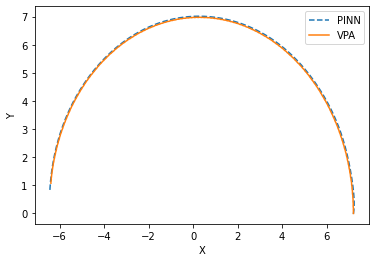

In [38]:
#绘制轨迹，2维
plt.plot(x_coordinates,y_coordinates,linestyle='--', label='PINN')
plt.plot(x_real_plt, y_real_plt,label='VPA')


plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
# plt.title('PINN results VS classic results')
plt.show()

In [447]:
file_lists = [x_coordinates, y_coordinates, z_coordinates]
file_names = ['hh_outputx.txt', 'hh_outputy.txt', 'hh_outputz.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)


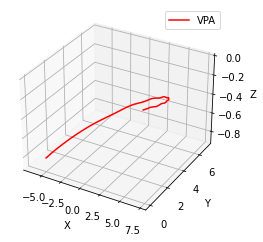

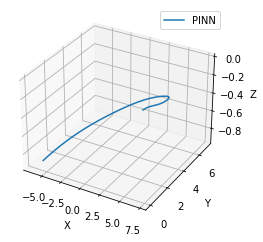

In [39]:
# 绘制轨迹 3维
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_plt[::int(n_all/50)], y_plt[::int(n_all/50)] ,z_plt[::int(n_all/50)],color='red',label='VPA')
#ax.plot(x_coordinates[::int(n_all/100)],y_coordinates[::int(n_all/100)],z_coordinates[::int(n_all/100)],label='neural network')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('Particle Motion in Electromagnetic Field')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot(x_plt[::int(n_all/100)], y_plt[::int(n_all/100)] ,z_plt[::int(n_all/100)],label='classic computation')
ax.plot(x_coordinates[::int(n_all/50)],y_coordinates[::int(n_all/50)],z_coordinates[::int(n_all/50)],label='PINN')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('Particle Motion in Electromagnetic Field')
plt.show()

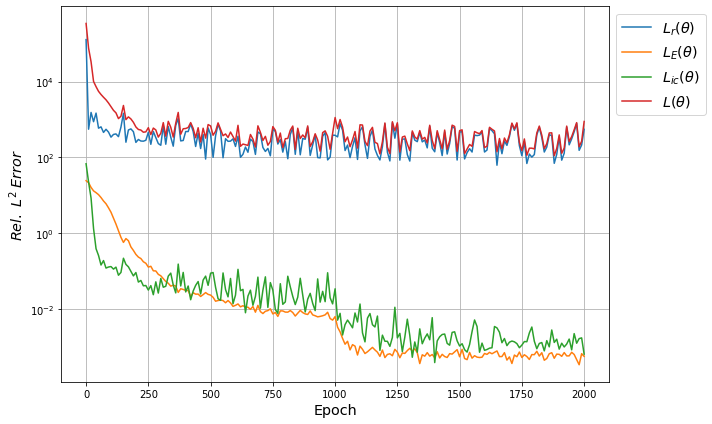

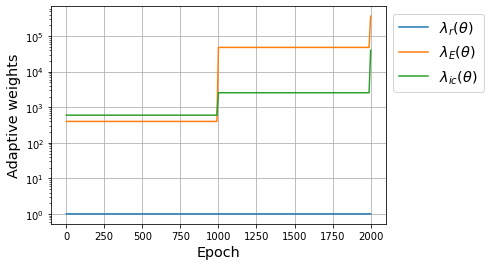

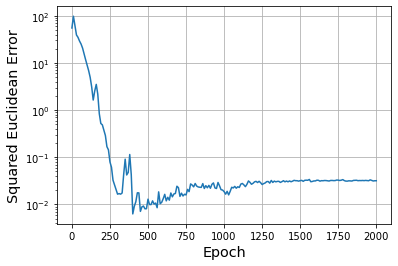

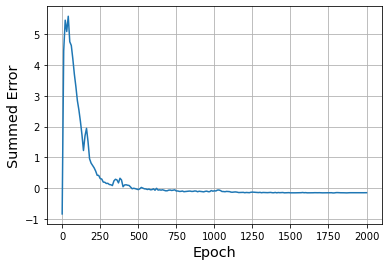

In [30]:
#绘制各loss成分随训练次数epoch变化图
epoch_total = len(loss_list)
epoch_array = np.array(range(0, epoch_total * n_epoch, n_epoch))

plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(epoch_array,lpde_list,label=r'$L_{r}(\theta)$')
#plt.plot(epoch_array,lmiu_list, label='Loss of μ ')
plt.plot(epoch_array,lE_list, label=r'$L_{E}(\theta)$')
plt.plot(epoch_array,l0_list, label=r'$L_{ic}(\theta)$')
plt.plot(epoch_array,loss_list, label=r'$L(\theta)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title(r'$Convergence\;of\;rel.\;L^2\;error\;during\;training\;process$')
# 添加图例并设置字体大小，并将其放在图形外部
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))


plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()


plt.plot(epoch_array,lamda1_list,label=r'$λ_{r}(\theta)$')
plt.plot(epoch_array,lamda2_list,label=r'$λ_{E}(\theta)$')
plt.plot(epoch_array,lamda3_list,label=r'$λ_{ic}(\theta)$')
#plt.plot(epoch_array,lamda4_list,label='λ for loss of μ')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Adaptive weights', fontsize='x-large')
# plt.title('Adaptive weights during training process')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()#绘图

plt.plot(epoch_array,loss_test_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric difference of position from classic data during training process')

plt.show()#绘图

plt.plot(epoch_array,lossmean_test_list)
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')
# plt.title('Arithmetic difference of position from classic data during training process')

plt.show()#绘图

In [31]:
#绘制损失函数在各时刻的分布
lpde_tl_list=[]

lE_tl_list=[]

loss_test_tl_list=[]

lossmean_test_tl_list=[]
for i in range(jump,(n_all+1+jump),10):
    t_tl = torch.tensor([i*interval]).view(-1, 1).requires_grad_(True)#tl:trainloss
    x_tl = u(t_tl)[:,0]
    y_tl = u(t_tl)[:,1]
    z_tl = u(t_tl)[:,2]
    vx_tl = gradients(x_tl, t_tl, 1)
    vy_tl = gradients(y_tl, t_tl, 1)
    vz_tl = gradients(z_tl, t_tl, 1)
    lpde1_tl = loss(gradients(vx_tl, t_tl, 1), q_over_m*(Ex + vy_tl * Bz(x_tl,y_tl,z_tl) - vz_tl * By(x_tl,y_tl,z_tl)))
    lpde2_tl = loss(gradients(vy_tl, t_tl, 1), q_over_m*(Ey + vz_tl * Bx(x_tl,y_tl,z_tl) - vx_tl * Bz(x_tl,y_tl,z_tl)))
    lpde3_tl = loss(gradients(vz_tl, t_tl, 1), q_over_m*(Ez + vx_tl * By(x_tl,y_tl,z_tl) - vy_tl * Bx(x_tl,y_tl,z_tl)))
    lE_tl = loss((vx_tl**2+vy_tl**2+vz_tl**2)**0.5,tensortarget)
    lpde_tl = lpde1_tl + lpde2_tl + lpde3_tl
    x_real_tl = x_real_plt[i-jump]
    y_real_tl = y_real_plt[i-jump]
    z_real_tl = z_real_plt[i-jump]
    vx_real_tl = vx_real_plt[i-jump]
    vy_real_tl = vy_real_plt[i-jump]
    vz_real_tl = vz_real_plt[i-jump]
    loss_test_tl = loss(x_tl,x_real_tl)+loss(y_tl,y_real_tl)+loss(z_tl,z_real_tl)
    lossmean_test_tl = (x_tl-x_real_tl+y_tl-y_real_tl+z_tl-z_real_tl)
    lpde_tl_list.append(lpde_tl.item())
    lE_tl_list.append(lE_tl.item())
    loss_test_tl_list.append(loss_test_tl.item())
    lossmean_test_tl_list.append(lossmean_test_tl.item())
tl_array = np.arange(jump*interval, (n_all+1+jump)*interval, 10*interval)




C:\Users\hxm\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


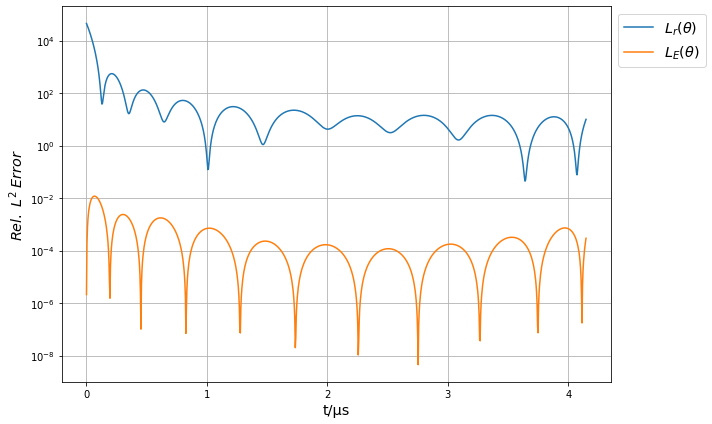

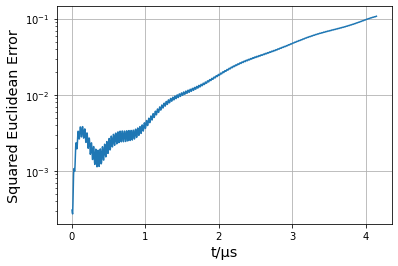

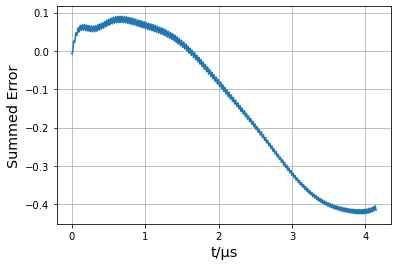

In [40]:
plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(tl_array,lpde_tl_list,label=r'$L_{r}(\theta)$')
plt.plot(tl_array,lE_tl_list,label=r'$L_{E}(\theta)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title('Loss of ODEs and loss of E from real data during motion process')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()

plt.plot(tl_array,loss_test_tl_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric differences of position from real data during motion process')

plt.show()#绘图

plt.plot(tl_array,lossmean_test_tl_list)
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')
# plt.title('Arithmetic differences of position from real data during motion process')

plt.show()#绘图

In [36]:
file_lists = [lpde_tl_list,  lE_tl_list,  loss_test_tl_list, lossmean_test_tl_list]
file_names = ['hh_lpde_tl_list.txt', 'hh_lE_tl_list.txt',  'hh_loss_test_tl_list.txt', 'hh_lossmean_test_tl_list.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)
